<h1><center>Laboratorio 10: Interpretabilidad 🤖</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesor: Ignacio Meza, Gabriel Iturra
- Auxiliar: Sebastián Tinoco
- Ayudante: Arturo Lazcano, Angelo Muñoz

### Estudiante:

- Mario González Otero


### **Link de repositorio de GitHub:** [ENLACE](https://github.com/mgzotero/MDS7202)

### Indice

1. [Temas a tratar](#Temas-a-tratar:)
3. [Descripcción del laboratorio](#Descripción-del-laboratorio.)
4. [Desarrollo](#Desarrollo)

## Temas a tratar

- Clasificación usando `XGBoost`.
- Métodos Agnósticos Globales de Interpretabilidad (`Partial Dependence Plot`, `Permutation Feature Importance`)
- Métodos Agnósticos Locales de Interpretabilidad (`Scoped Rules`, `SHAP`)

## Reglas:

- **Grupos de 2 personas**
- Asistencia **obligatoria** a instrucciones del lab (viernes 16.15). Luego, pueden quedarse trabajando en las salas o irse.
- **No se revisarán entregas de personas ausentes**.
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias.
- Pueden usar cualquer matrial del curso que estimen conveniente.

### Objetivos principales del laboratorio

- Generar un pipeline de clasificación con `XGBoost`.
- Implementar modelos de interpretabilidad para explicar el funcionamiento del modelo de clasificación.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

# 1. Problemas Clínicos del Dr. Simi

<p align="center">
  <img src="https://gantz.cl/wp-content/uploads/2020/01/79024136_2718114448239059_7240913062570491904_o.jpg" width="350">
</p>

El reconocido **Dr. Simi**, famoso vendedor de medicamentos en latinoamerica, debido a la creciente prevalencia de enfermedades crónicas, como la diabetes, decidió abrir una clínica especializada en el tratamiento de esta enfermedad en nuestro país.

La clínica del Doctor Simi se convirtió en un lugar donde los pacientes con diabetes podrían recibir atención médica integral. El personal médico estaba compuesto por especialistas en endocrinología, nutrición y enfermería, todos capacitados en el manejo de la diabetes.

Sin embargo él se ha dado cuenta que los tiempos han cambiado y gracias a las tecnologías es posible generar mejores predicciones en la diabetes conociendo el historial médico de las personas. Por esto, el doctor se ha colocado una meta de incluir modelos de machine learning dentro de sus clínicas, para ello le ha solicitado crear un modelo capaz de predecir/clasificar diabetes pero le rogó que el desarrollo del modelo tuviera un especial enfoque en la interpretabilidad de lo que hace su modelo.

Para que usted pueda entrenar el modelo, Dr. Simi le ha entregado un dataset de todos los clientes que fueron detectados con diabetes a lo largo de la historia de la clinica. Con ello, adjunta el historial médico de las personas en forma de datos tabulares para que usted pueda realizar fácilmente la clasificación.


In [134]:
!pip install alibi shap optuna

In [135]:
import numpy as np
import pandas as pd

SEED = 124434

In [136]:
df = pd.read_csv("diabetes_data.csv")
df.head(4)

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
0,4.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,0.0,1.0,0.0
1,12.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
2,13.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0
3,11.0,1.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0


In [137]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,70692.0,8.584055,2.852153,1.0,7.0,9.0,11.0,13.0
Sex,70692.0,0.456997,0.498151,0.0,0.0,0.0,1.0,1.0
HighChol,70692.0,0.525703,0.499342,0.0,0.0,1.0,1.0,1.0
CholCheck,70692.0,0.975259,0.155336,0.0,1.0,1.0,1.0,1.0
BMI,70692.0,29.856985,7.113954,12.0,25.0,29.0,33.0,98.0
Smoker,70692.0,0.475273,0.499392,0.0,0.0,0.0,1.0,1.0
HeartDiseaseorAttack,70692.0,0.147810,0.354914,0.0,0.0,0.0,0.0,1.0
PhysActivity,70692.0,0.703036,0.456924,0.0,0.0,1.0,1.0,1.0
Fruits,70692.0,0.611795,0.487345,0.0,0.0,1.0,1.0,1.0
Veggies,70692.0,0.788774,0.408181,0.0,1.0,1.0,1.0,1.0


## 2. Clasificación de pacientes con diabetes (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/QH--g3ZaSbsAAAAC/dr-simi-abrazo.gif" width="400">
</p>

En primer lugar, el reconocido doctor le pide entrenar un modelo de `XGBoost` utilizando como target la columna `Diabetes` del dataset `diabetes_data.csv`. Para el entrenamiento tome en cuenta **todos** los pasos necesarios para entrenar un modelo de aprendizaje supervisado vistos hasta la fecha (use `Pipeline`, `ColumnTransformer`, etc.), comente sus decisiones y los resultados obtenidos con el modelo. ¿Es acaso un buen predictor de diabetes?, ¿Qué buscan explicar las métricas utilizadas?, ¿las métricas utilizadas para medir la predictibilidad le permiten asegurar que su modelo haga una buena elección de las features?.

In [138]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import optuna
import shap

import warnings
warnings.filterwarnings("ignore")

import pickle

In [139]:
features = [feature for feature in df.columns.tolist() if feature != "Diabetes"]
target = "Diabetes"

X_train, X_test, y_train, y_test = train_test_split(
    df[features],
    df[target],
    test_size=0.2,
    random_state=SEED
)

In [140]:
# def obj_func(trial):
#     transformer = make_column_transformer(
#         (MinMaxScaler(), features)
#     ).set_output(transform="pandas")

#     pipeline = make_pipeline(
#         transformer,
#         xgb.XGBClassifier(random_state=SEED)
#     )

#     params = {
#         "xgbclassifier__learning_rate": trial.suggest_float("xgbclassifier__learning_rate", 0.001, 0.1),
#         "xgbclassifier__n_estimators": trial.suggest_int("xgbclassifier__n_estimators", 50, 1000),
#         "xgbclassifier__max_depth": trial.suggest_int("xgbclassifier__max_depth", 3, 10),
#         "xgbclassifier__max_leaves": trial.suggest_int("xgbclassifier__max_leaves", 0, 100),
#         "xgbclassifier__min_child_weight": trial.suggest_int("xgbclassifier__min_child_weight", 1, 5),
#         "xgbclassifier__alpha": trial.suggest_float("xgbclassifier__alpha", 0, 1),
#         "xgbclassifier__lambda": trial.suggest_float("xgbclassifier__lambda", 0, 1),
#     }

#     pipeline.set_params(**params)
#     pipeline.fit(X_train, y_train)
#     metric = accuracy_score(y_test, pipeline.predict(X_test))

#     return metric

# study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=SEED))
# study.optimize(obj_func, n_trials=500, timeout=300)

In [141]:
# transformer = make_column_transformer(
#     (MinMaxScaler(), features)
# ).set_output(transform="pandas")

# pipeline = make_pipeline(
#     transformer,
#     xgb.XGBClassifier(random_state=SEED)
# )

# pipeline.set_params(**study.best_params)

In [142]:
# with open("pipeline.pkl", "wb") as f:
#     picke.dump(pipeline, f)

with open("pipeline.pkl", "rb") as f:
    pipeline = pickle.load(f)

In [143]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['Age', 'Sex', 'HighChol',
                                                   'CholCheck', 'BMI', 'Smoker',
                                                   'HeartDiseaseorAttack',
                                                   'PhysActivity', 'Fruits',
                                                   'Veggies',
                                                   'HvyAlcoholConsump',
                                                   'GenHlth', 'MentHlth',
                                                   'PhysHlth', 'DiffWalk',
                                                   'Stroke', 'HighBP'])])),
                ('xgbclassifier',
                 XGBClassifier(alpha=0.9957511003060702,...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               lambda=0.8519265575845456,
                               learning_rate=0.0788414994475937, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=4, max_leaves=47,
                               min_child_weight=5, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=183, n_jobs=None, ...))])

In [144]:
print(f"Accuracy: {accuracy_score(y_test, pipeline.predict(X_test)):.4f}")
print(f"Recall: {recall_score(y_test, pipeline.predict(X_test)):.4f}")
print(f"Precision: {precision_score(y_test, pipeline.predict(X_test)):.4f}")
print(f"F1-Score: {f1_score(y_test, pipeline.predict(X_test)):.4f}")
print(f"AUC: {roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1]):.4f}")

Accuracy: 0.7556
Recall: 0.8003
Precision: 0.7312
F1-Score: 0.7642
AUC: 0.8357


Es posible observar que el modelo obtiene las siguientes métricas:

- Accuracy: 75.56%
- Recall: 80.03%
- Precision: 73.12%
- F1-Score: 76.42%
- AUC: 83.57%

En términos de accuracy el modelo es relativamente mediocre al alcanzar un score menor al 80%, sin embargo en términos de recall sí se tiene un mejor desempeño al realizar la comparación con la métrica anterior. Esto es interesante, ya que si se tiene en consideración que el "costo" de un falso positivo es menor al de un falso negativo (bajo el razonable supuesto de que la salud de una persona sea lo más importante), se puede considerar que el modelo "cumple" con el objetivo de detectar a tiempo una *posible* diabetes, esto con el fin de proporcionar un tratamiento clínico adecuado.

Esto no quiere decir que un modelo que prediga diabetes para cada punto de datos es un buen modelo, sin embargo, en vista y considerando el contexto del problema, hay que asumir la existencia de este "trade-off" entre recall y precision, por lo que, evidentemente, prevenir una posible diabetes (aunque después no lo sea) es mejor que dejar a un paciente sin tratamiento cuando éste lo necesitaba.

A continuación se muestra un gráfico en donde se puede visualizar el grado de separabilidad entre clases que logra el modelo.

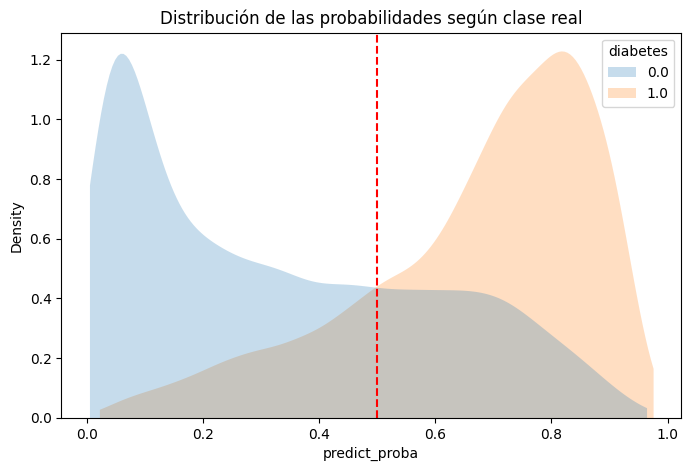

In [145]:
probs_and_realclasses = pd.DataFrame(
    {
        "predict_proba": pipeline.predict_proba(X_test)[:, 1],
        "diabetes": y_test,
    }
)

fig, ax = plt.subplots(figsize=(8, 5))

sns.kdeplot(
    data=probs_and_realclasses,
    x="predict_proba",
    hue="diabetes",
    fill=True,
    linewidth=0,
    cut=0,
    ax=ax,
)
ax.set_title("Distribución de las probabilidades según clase real")
ax.axvline(x=0.5, linestyle="dashed", c="red")

fig.show()

## 3. Importancia de las features con XGBoost (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/5JAj5_IiagEAAAAd/dr-simi-dr-simi-dance.gif" width="400">
</p>

Para añadir el toque de interpretabilidad que Dr. Simi le pide, se le pide calcular la **importancia de las features** del modelo entrenado utilizando todos los métodos (*weight*, *cover*, *gain*) que posee xgboost usando `plot_importance`. ¿Los resultados obtenidos con los diferentes métodos son compatibles?, comente sus resultados y a que se debe la igualdad o desigualdad que ve en los resultados. Finalmente, ¿las importancias obtenidas son suficientes para obtener la interpretabilidad de un modelo que utiliza árboles? ¿Qué debilidad presenta este método?

Antes de generar los distintos gráficos de importancia de features, hay que tener presente el significado de cada "tipo de importancia":

- **Weight:** representa el número de veces que una feature aparece en un árbol a lo largo de todos los árboles en el bosque. Cuantas más veces aparezca una feature, mayor es su importancia.

- **Gain:** mide la mejora promedio de la métrica de rendimiento al agregar una feature en particular a los árboles.

- **Cover:** representa la cobertura relativa de una feature. Se define como la cantidad de veces que una feature aparece en los árboles multiplicada por la profundidad promedio de esos árboles.

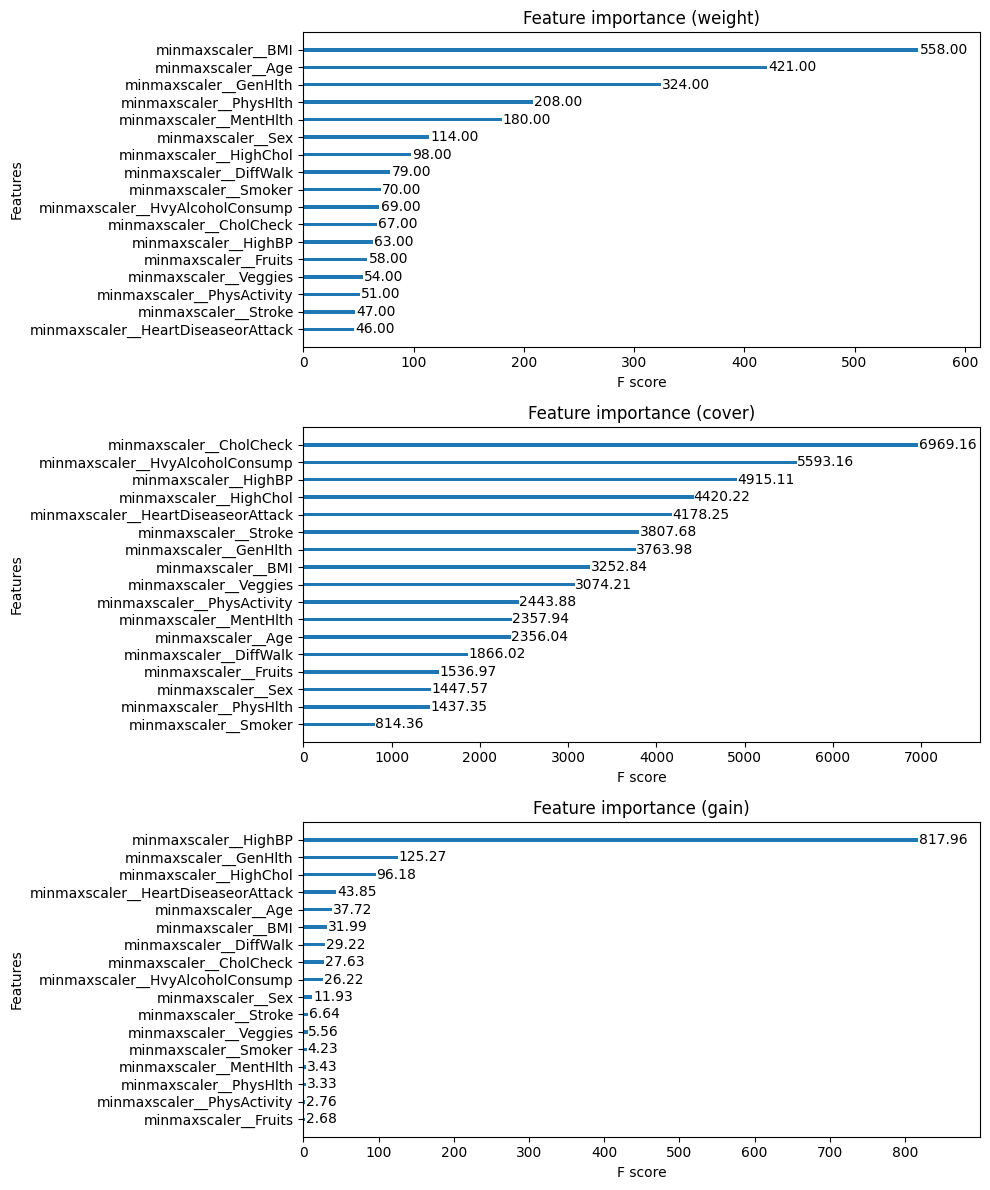

In [146]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 12), nrows=3)

plot_importance_weight = xgb.plot_importance(pipeline.named_steps["xgbclassifier"], importance_type="weight", ax=ax1)
plot_importance_cover = xgb.plot_importance(pipeline.named_steps["xgbclassifier"], importance_type="cover", ax=ax2)
plot_importance_gain = xgb.plot_importance(pipeline.named_steps["xgbclassifier"], importance_type="gain", ax=ax3)

for ax in (ax1, ax2, ax3):
    ax.grid(False)

for texts in (plot_importance_weight.texts, plot_importance_cover.texts, plot_importance_gain.texts):
    for text in texts:
        text.set_text(f'{round(float(text.get_text()), 2):.2f}')

title = "Feature importance"
ax1.set_title(f"{title} (weight)")
ax2.set_title(f"{title} (cover)")
ax3.set_title(f"{title} (gain)")

fig.tight_layout()
fig.show()

Si bien las importancias de las features proporcionadas por lo métodos integrados por XGBoost pueden llegar a ofrecer información relevante acerca de qué features son más influyentes que otras en términos de la toma de decisiones de los árboles subyacentes, hay que tener presente que estas "importancias" tienden a sobrevalorar features que tienen una alta cardinalidad o que están correlacionadas con otras features importantes, además de depender bastamente de la dispersión de los datos. Por lo mismo, hay que ser cautelosos con la interpretación de las importancias, pues no siempre se trata de causalidad.

En cuanto a los gráficos, es posible observar que estos presentan resultados heterogéneos:

- En el gráfico de `weight`, las tres features más importantes son `BMI`, `Age` y `GenHlth`.

- En el gráfico de `cover`, las tres features más importantes son `CholCheck`, `HvyAlcoholConsump` y `HighBP`, mientras que `Age` es la sexta feature menos importante.

- En el gráfico de `gain`, las tres features más importantes son `HighBP` (por mucha diferencia), `GenHlth` y `HighChol`.

Cabe destacar que si una feature es importante en un tipo de importancia pero no en otro, puede ser indicativo de cómo esa feature contribuye de manera única a diferentes aspectos del rendimiento del modelo. También puede ser útil considerar cómo estas features están correlacionadas y si las métricas de importancia reflejan adecuadamente sus roles en el modelo. Por supuesto, el explorar visualmente gráficos de dependencia parcial (PDP) y realizar análisis más detallados puede ayudar a comprender mejor estas diferencias.

## 4. Métodos Agnósticos Globales (1.0 puntos)

<p align="center">
  <img src="https://media.tenor.com/JcRHtjVuXN8AAAAC/dr-simi-farmacias-similares.gif" width="400">
</p>

Para mitigar los problemas encontrados en la sección anterior, Dr. Simi le pide implementar un **método de permutación** que le permita observar la importancia de las features. Visualice los resultados de este método en un gráfico. Para que su modelo sea consistente, repita el proceso **30 veces** y verifique la desviación estándar de sus resultados (¿Qué señala está?). Además, responda las siguientes preguntas:


- ¿Cómo mide la importancia de las features su propuesta?
- ¿Qué features tienen un mayor impacto en la salida del modelo?. Comente las 5 primeras, ¿Tienen sentido?
- ¿Cómo cambian sus conclusiones con respecto a las features importances del punto anterior?
- Nombre y explique 3 ventajas y 3 desventajas del método implementado.

El método de permutación es una técnica agnóstica global que sirve para evaluar la importancia relativa de las features al permutar aleatoriamente las filas de columna específica para luego ver cómo esta permutación afecta el rendimiento del modelo.

In [147]:
from sklearn.inspection import permutation_importance

res = permutation_importance(
    pipeline, X_test, y_test, n_repeats=30, random_state=SEED
)
perm_sorted_idx = res.importances_mean.argsort()

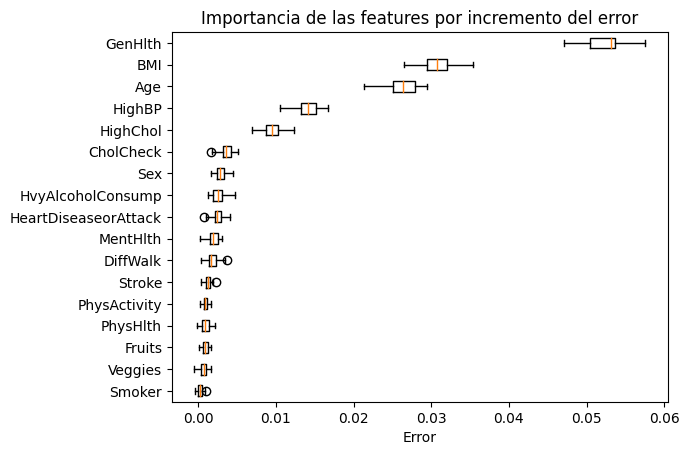

In [148]:
fig, ax = plt.subplots()
ax.boxplot(
    res.importances[perm_sorted_idx].T,
    vert=False,
    labels=X_test.columns[perm_sorted_idx],
)
ax.set_title("Importancia de las features por incremento del error")
ax.set_xlabel("Error")
fig.show()

Es posible observar que las cinco features más importantes para el modelo según el método de permutación son:

- `GenHlth` (genética).
- `BMI` (Índice de Masa Corporal).
- `Age` (edad).
- `HighBP` (alta presión arterial).
- `HighChol` (alto coresterol).

Las cuales tienen sentido, pues son variables que "en promedio" aparecen como importantes según los criterios anteriores (weight, cover y gain), además de que resultan ser features que, a priori, uno pensaría como los primeros indicadores para pensar si una persona pudiera ser propenso a diabetes o no.

Con respecto a los criterios anteriores, por supuesto, las conclusiones pueden cambiar, ya que el método de permutación tiene en cuenta la interacción y correlación entre features, por lo que puede ofrecer una visión más completa y precisa.

En términos de ventajas y desventajas de este método, se presenta la siguiente tabla:


| **Ventajas**                                    | **Desventajas**                                |
| ----------------------------------------------- | ---------------------------------------------- |
| Considera interacciones entre features   | Computacionalmente costoso                    |
| Robusto a suposiciones de modelos                | Dependiente de la métrica                      |
| Generalizable a diferentes tipos de modelos (agnóstico)     | No captura interacciones no lineales complejas |

## 5. Métodos Agnósticos Locales (2.0 puntos)

<p align="center">
  <img src="https://i.makeagif.com/media/1-27-2017/fBrzT8.mp4" width="400">
</p>

### 5.1 Calculando Shap Values (0.4 puntos)

Alegre por saber cómo funciona el modelo de predicción a nivel general, Dr. Simi le pide ahora interpretar las predicciones de su modelo a nivel de paciente (es decir, desde un punto de vista **local**). Para esto, el ilustre farmacéutico le pide calcular los *shap values* de su modelo. ¿Qué representa cada número en su resultado? ¿Es posible atribuir un significado a la positividad/negatividad de cada valor?

In [149]:
explainer = shap.TreeExplainer(pipeline["xgbclassifier"])
shap_values = explainer(df[features])

In [150]:
shap_values

.values =
array([[ 0.22635707,  0.05966038, -0.33926842, ...,  0.00979577,
        -0.0022924 ,  0.35938653],
       [ 0.15093362,  0.07684075,  0.26079825, ..., -0.03178352,
         0.16003263,  0.38831437],
       [ 0.34892538,  0.04936917, -0.28486866, ...,  0.01474618,
        -0.00942354, -0.45818433],
       ...,
       [-0.03807639, -0.07286131,  0.27453032, ...,  0.14576674,
        -0.01542145,  0.3526674 ],
       [-0.02569918, -0.0615714 ,  0.28883636, ...,  0.12240551,
        -0.01575323,  0.38367516],
       [-0.00359779, -0.06195004,  0.22153626, ..., -0.02417459,
        -0.02024059,  0.34953785]], dtype=float32)

.base_values =
array([0.00252743, 0.00252743, 0.00252743, ..., 0.00252743, 0.00252743,
       0.00252743], dtype=float32)

.data =
array([[ 4.,  1.,  0., ...,  0.,  0.,  1.],
       [12.,  1.,  1., ...,  0.,  1.,  1.],
       [13.,  1.,  0., ...,  0.,  0.,  0.],
       ...,
       [13.,  0.,  1., ...,  1.,  0.,  1.],
       [11.,  0.,  1., ...,  1.,  0.,  1.]

Un valor SHAP (SHapley Additive exPlanations) para una feature específica en una instancia de datos indica cuánto contribuye esa feature a la diferencia entre la predicción del modelo para esa instancia y la predicción promedio del modelo en todo el conjunto de datos.

Un SHAP positivo (negativo) significa que la presencia de esa feature aumenta (disminuye) la predicción del modelo en comparación con el valor base (promedio de todo el dataset).

### 5.2 Aporte local (0.4 puntos)

Usando los *shap values* calculados, grafique el **aporte** de las diferentes variables para las instancias **1**, **9** y **150**, interprete sus resultados y responda:
- ¿Qué variables afectan de manera positiva/negativa a la probabilidad de poseer diabetes?
- ¿Existe algún patrón común entre las instancias analizadas?
- ¿Es posible generalizar estas conclusiones a todo el dataset?

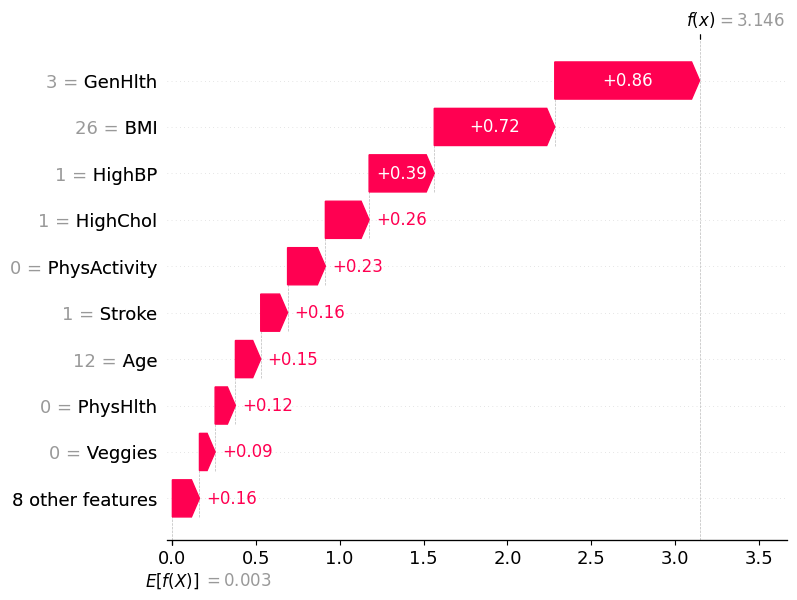


 1


In [151]:
idx = 1

shap.plots.waterfall(shap_values[idx, :])
print("\n", pipeline.predict(df[features])[idx])

Para la instancia 1 es posible observar que toda su configuración de features contribuye de manera positiva a la probabilidad de padecer diabetes, destacando la gran relevancia de la feature `GenHlth`, el tener un alto IMC, un alto colesterol, una alta presión arterial y el no realizar ejercicio físico.

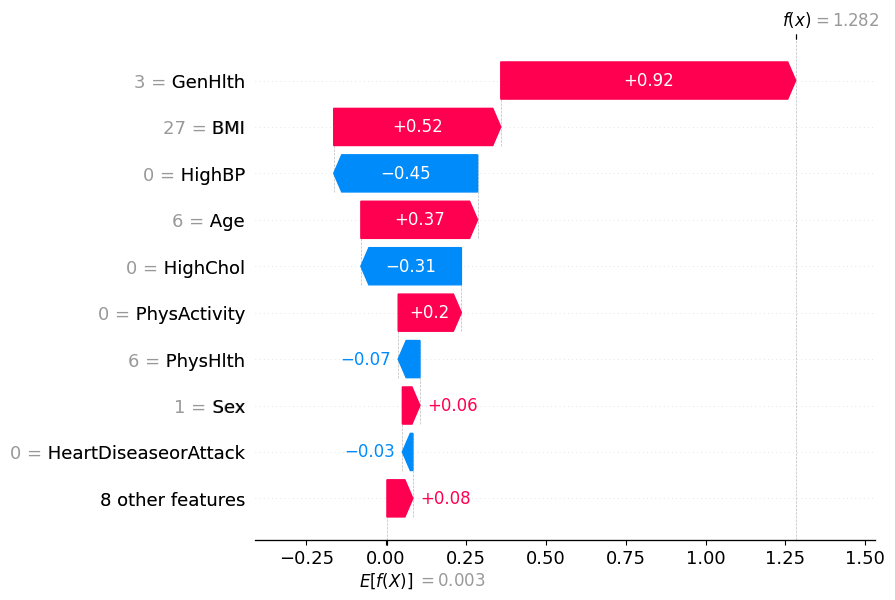


 0


In [152]:
idx = 9

shap.plots.waterfall(shap_values[idx, :])
print("\n", pipeline.predict(df[features])[idx])

Para la instancia 9 es posible observar que ciertas features contribuyen de manera positiva (disposición genética, un alto IMC y el no hacer ejericio físico, por ejemplo), mientras que otras lo hacen de manera negativa (el no tener tanto una alta presión arterial como un alto colesterol). La contribucion de las variables de `HighBP` y `HighChol` son lo suficientemente importantes como para contraponerse a las contribuciones positivas, dando como resultado una predición de "no diabetes".

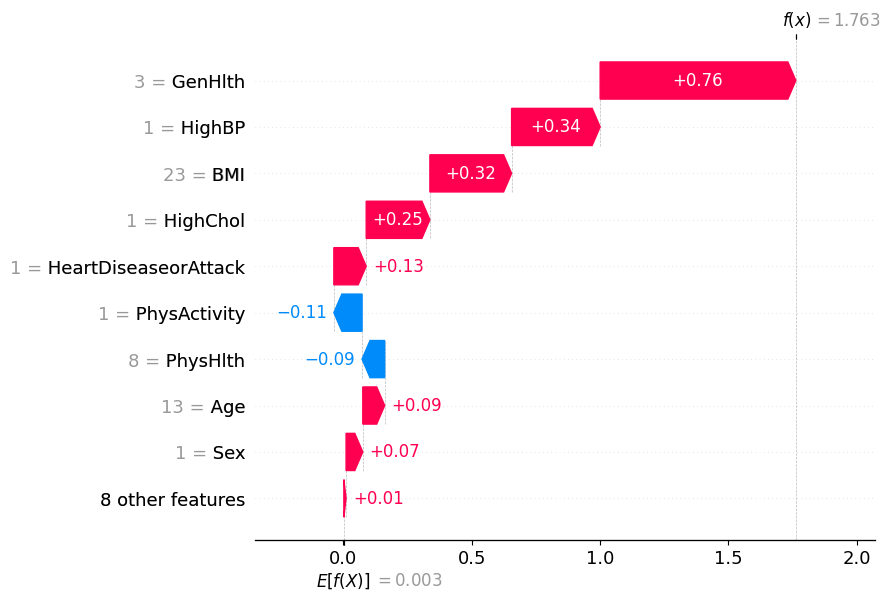


 1


In [153]:
idx = 150

shap.plots.waterfall(shap_values[idx, :])
print("\n", pipeline.predict(df[features])[idx])

Para la instancia 150 es posible observar que ciertas features contribuyen de manera positiva (disposición genética, un alto IMC, una alta presión arterial y un alto colesterol, por ejemplo), mientras que otras lo hacen de manera negativa (el no tener tanto una alta presión arterial como un alto colesterol). La contribucion de las variables de `HighBP` y `HighChol` son lo suficientemente importantes como para contraponerse a las contribuciones positivas, dando como resultado una predición de "no diabetes".

Si bien existen patrones que se encuentran en las tres instancias (tales como una contribución positiva por parte de la disposición genética `GenHlth`, un alto índice de masa corporal `BMI`, un alto colesterol `HighChol` y una alta presión arterial `HighBP`), hay que tener cuidado al generalizar a todas las instancias, pues puede que las magnitudes de los efectos no sean exactamente los mismos en el resto del dataset (pues la disposición del resto de features iría variando).

### 5.3 Aporte global (0.4 puntos)

Genere ahora una visualización donde se grafique el aporte de cada feature a nivel **global** e interprete sus resultados. ¿Qué diferencias existen con las conclusiones generadas a nivel de instancia?

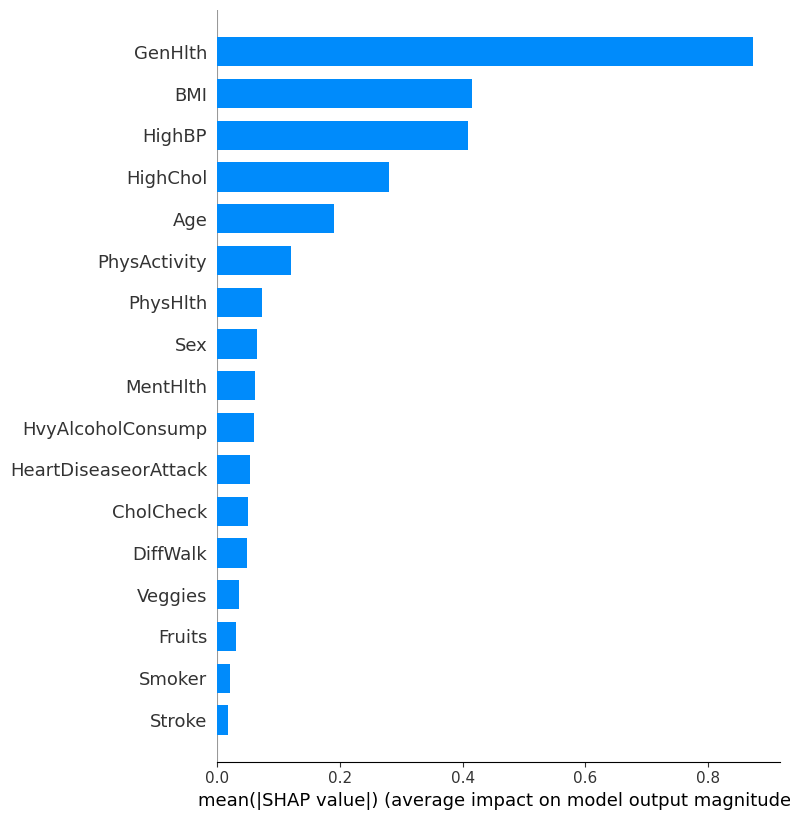

In [154]:
shap.summary_plot(shap_values, df[features], plot_type="bar")

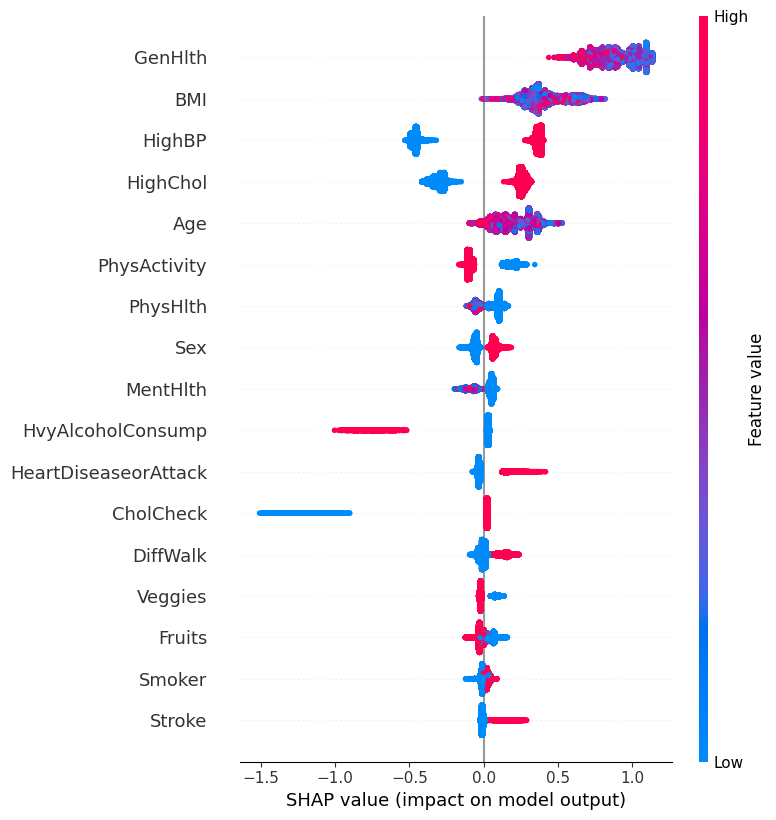

In [155]:
shap.summary_plot(shap_values, df[features])

Es posible ver que sí se mantienen las conclusiones heredadas de la sección anterior, pues se observa que las features `GenHlth`, `BMI`, `HighBP` y `HighChol` mantienen su relevancia en promedio cuando miramos al dataset completo. Cabe destacar ciertas features cuyos SHAP values se "activan" solo cuando toman un valor específico (tales como `ColCheck` y `HvyAlcoholConsump`).

### 5.4 Scatter plot (0.4 puntos)

Grafique ahora un *scatterplot* entre los *shap values* y las primeras 5 features con mayor impacto global (un gráfico por cada feature), coloreando cada punto por la probabilidad de tener diabetes. ¿Qué puede concluir de sus resultados?

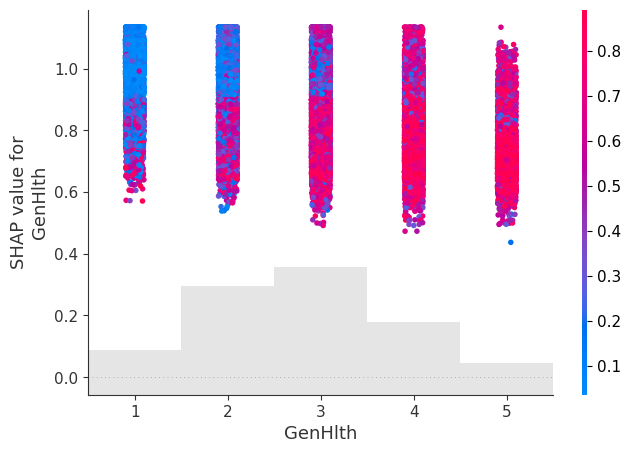

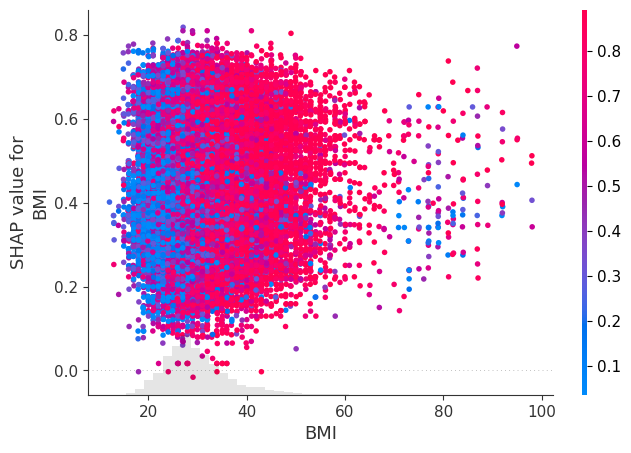

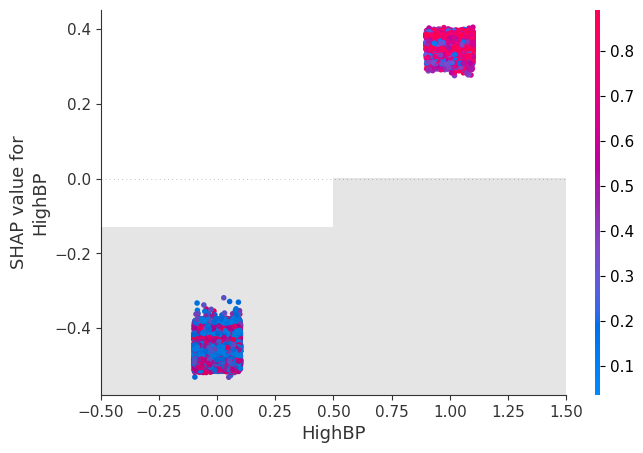

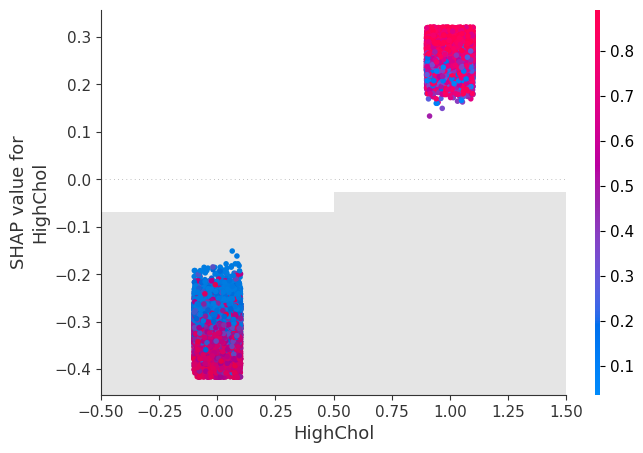

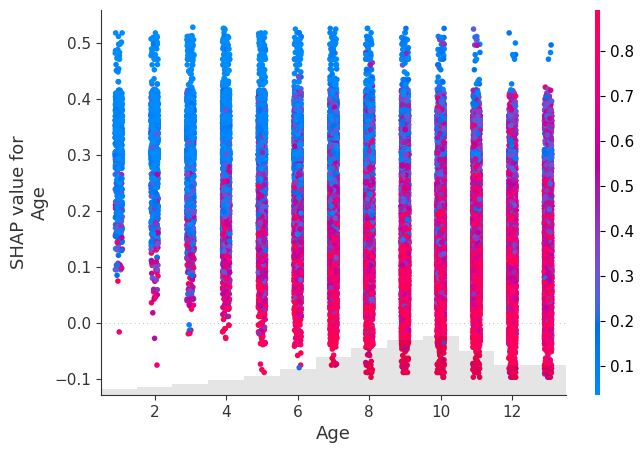

In [156]:
shap_values_abs = np.mean(np.abs(shap_values.values), axis=0)
feature_importance_names = X_train.columns[shap_values_abs.argsort()[::-1]]
for name in feature_importance_names[:5]:
    shap.plots.scatter(
        shap_values[:, name],
        color=pipeline.predict_proba(df[features])[:, 1],
    )

De los gráficos anteriores se puede dilucidar:

- A medida que aumenta el valor de la variable `GenHlth`, aumenta la probabilidad de que el paciente posea diabetes.
- A partir de cierto umbral de `BMI` (~30), las probabilidades de tener diabetes aumentan.
- El tener un una alta presión alterial (`HighBP`=1) es en promedio un buen indicador para tener una alta probabilidad de tener diabetes. Lo mismo sucede con `HighChol`.
- Para la variable de edad (`Age`) los SHAP values están altamente distribuidos sobre los valores de edad, aunque existe una muy pequeña tendencia (muy dispersa) respecto a que a medida que aumenta la edad disminuyen los SHAP values, es decir, mientras más edad, la contribución de esta variable se hace menos relevante (o levemente negativa) para predecir la diabetes. Aunque cabe destacar que aquellas edades más grandes concentran las mayores probabilidades de padecer la enfermedad, por lo que da para pensar que en esos casos otras features toman más relevancia.

### 5.5 Partial Dependence Plot (0.4 puntos)

Finalmente, se le pide generar un gráfico del tipo **Partial Dependence Plot** para las mismas 5 variables con mayor impacto global usando una submuestra de **1000 observaciones**. ¿Qué relación existe entre la salida promedio del modelo y cada feature analizada? ¿Son estas conclusiones generalizables para todo el conjunto de datos?

In [157]:
X1000 = shap.utils.sample(
    df[features],
    1000,
    random_state=SEED
)

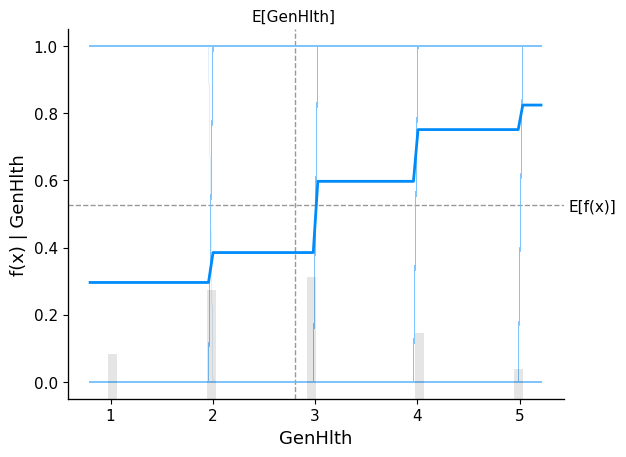

In [158]:
shap.partial_dependence_plot(
    "GenHlth",
    pipeline.predict,
    X1000,
    model_expected_value=True,
    feature_expected_value=True,
)

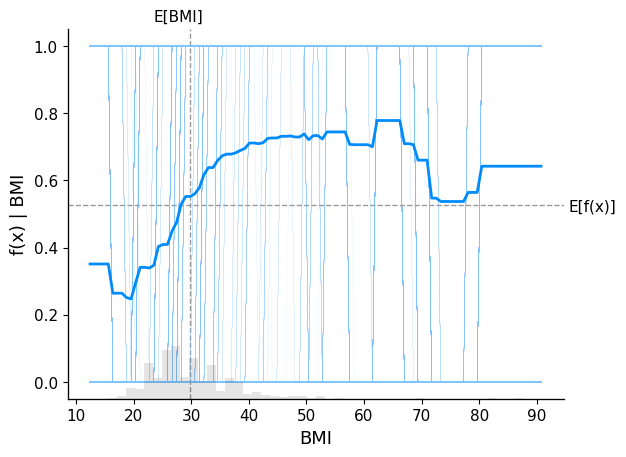

In [159]:
shap.partial_dependence_plot(
    "BMI",
    pipeline.predict,
    X1000,
    model_expected_value=True,
    feature_expected_value=True,
)

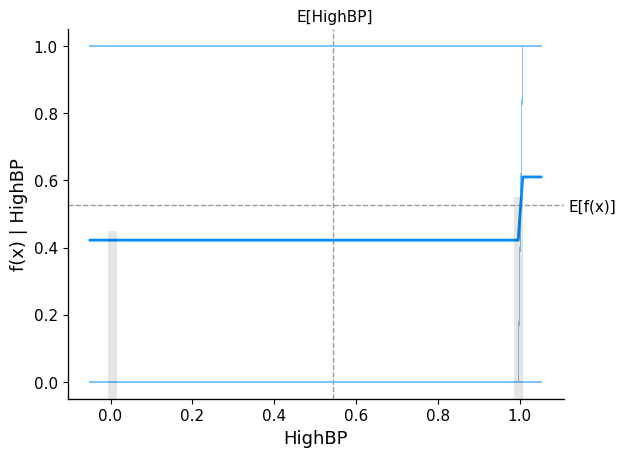

In [160]:
shap.partial_dependence_plot(
    "HighBP",
    pipeline.predict,
    X1000,
    model_expected_value=True,
    feature_expected_value=True,
)

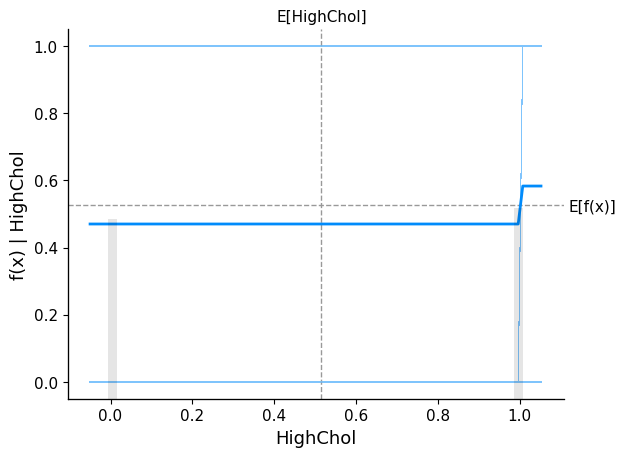

In [161]:
shap.partial_dependence_plot(
    "HighChol",
    pipeline.predict,
    X1000,
    model_expected_value=True,
    feature_expected_value=True,
)

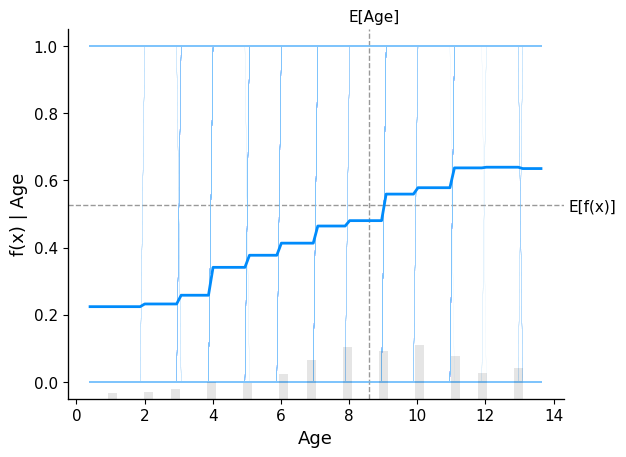

In [162]:
shap.partial_dependence_plot(
    "Age",
    pipeline.predict,
    X1000,
    model_expected_value=True,
    feature_expected_value=True,
)

De los gráficos anteriores se puede observar:

- La contribución marginal promedio de la variable `GenHlth` respecto a la probabilidad de padecer diabetes es creciente en todo el rango, en donde a partir de `GenHlth`=3, esta da un paso grande y supera el umbral de 50%.
- La contribución marginal promedio de la variable `BMI` respecto a la probabilidad de padecer diabetes es creciente en la mayor parte del rango, decreciendo desde `BMI`=65 (aprox.). Cabe destacar que a partir de `BMI`=30 (hasta el final), la probabilidad supera el umbral de 50%.
- La contribución marginal promedio de las variables `HighBP` y `HighChol` respecto a la probabilidad de padecer diabetes es creciente. En particular, cuando cada feature toma el valor 1, la probabilidad de padecimiento atraviesa el umbral del 50%.
- La contribución marginal promedio de la variable `Age` respecto a la probabilidad de padecer diabetes es creciente en todo su rango, atravesando el umbral del 50% cuando toma el valor 9.

Aunque estos insights hacen sentido, hay que tener en mente que estas son contribuciones marginales **promedio**, por lo que puede haber imprecisiones al querer adjudicar este comportamiento a algún datapoint.

## 6. Sistema de Reglas! (1.0 puntos)

<p align="center">
  <img src="https://media.baamboozle.com/uploads/images/125978/1638281150_1380186_gif-url.gif" width="400">
</p>

Después de todo el trabajo hecho, Dr. Simi le pide simplificar el funcionamiento de su modelo en un sistema de reglas que le permita explicar a sus clientes las predicciones que genera su modelo. En particular, Dr. Simi le pide explicar la decisión tomada para las observaciones **1000**, **3001** y **5751**. Con las reglas propuestas señale a **cuánta población** es posible explicar con estas reglas e indique la **precisión** que poseen las reglas en la totalidad de los datos. ¿Tienen sentido sus reglas propuestas para las observaciones?. Fundamente sus respuesta señalando el impacto que tienen sus reglas sobre todo el conjunto de datos.

In [163]:
from alibi.explainers import AnchorTabular

In [164]:
explainer = AnchorTabular(
    pipeline["xgbclassifier"].predict,
    feature_names=features,
    seed=SEED
)

explainer.fit(
    pipeline["columntransformer"].transform(X_train).values
)

AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'seed': 124434, 'disc_perc': (25, 50, 75)},
  'version': '0.9.4'}
)

In [165]:
class_names = ["no_diabetes", "diabetes"]

In [166]:
idx = 1000
explanation = explainer.explain(X_test.to_numpy()[idx], threshold=0.95)
print('Prediction: ', class_names[explainer.predictor(X_test.to_numpy()[idx].reshape(1, -1))[0]])
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)
print()

idx = 3001
explanation = explainer.explain(X_test.to_numpy()[idx], threshold=0.95)
print('Prediction: ', class_names[explainer.predictor(X_test.to_numpy()[idx].reshape(1, -1))[0]])
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)
print()

idx = 5751
explanation = explainer.explain(X_test.to_numpy()[idx], threshold=0.95)
print('Prediction: ', class_names[explainer.predictor(X_test.to_numpy()[idx].reshape(1, -1))[0]])
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

Prediction:  diabetes
Anchor: GenHlth > 0.75 AND HighChol > 0.00
Precision: 0.98
Coverage: 0.06

Prediction:  diabetes
Anchor: GenHlth > 0.50 AND BMI > 0.24
Precision: 0.95
Coverage: 0.10

Prediction:  diabetes
Anchor: GenHlth > 0.75 AND HighChol > 0.00
Precision: 0.98
Coverage: 0.06


De lo anterior, es posible observar que en las tres instancias la feature `GenHlth` siempre está presente, mientras que `HighChol` aparece en tan solo dos de ellas (cabe destacar que las tres instancias son predichas con diabetes).

La variable `GenHlth` es la más determinante en este caso para poder predecir el padecimiento de la diabetes, en conjunto con una variable `HighChol` igual a 1, por lo que, en estos casos, una predisposición genética junto a un colesterol alto son muy determinantes.

En cuanto a la precisión, esta es de 98%, 95% y 98% respectivamente, en conjunto con coberturas del 6%, 10% y 6% (c/r a la muestra de mil instancias).

Cabe mencionar que si bien estas reglas sí hacen sentido a priori, es necesario aclarar que poseen una baja cobertura, por lo que no son aplicables del todo para el dataset entero.

# Retrospectiva... (1.0 puntos)

En base a los diferentes métodos que implementa y ha comentado en este laboratorio, comente qué métodos le permiten entregar mejores conclusiones para la tarea de clasificación de diabetes. Por otro lado, ¿qué métodos son más útiles para el problema del doctor Simi, métodos agnosticos locales o globales?

Los gráficos `waterfall` y de `PDP` ligados a los SHAP values proporcionan un display intuitivo a la hora de ver los efectos marginales tanto locales como globales de cada feature según instancia y dataset entero respectivamente. Como recomendación, la mejor decisión no es restringirse a considerar un solo método, pues las técnicas globales y locales pueden ayudar a tener una mejor perspectiva de las decisiones del modelo. Tener en cuenta gráficos `PDP` ayuda a tener una perspectiva ex-ante y general de cómo afectan las distintas variables sobre la probabilidad de tener diabetes o no. En adición a esto, es útil también considerar un análisis local para poder luego tomar acciones médicas mucho más personalizadas según el paciente.

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

![Gracias Totales!](https://media.tenor.com/ctnq4bhZE3gAAAAC/drsimi-simi.gif)